In [79]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image


from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras_preprocessing import image

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from tensorflow.keras.models import load_model



In [2]:
dirData = 'C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset'
dirTrain = os.path.join(dirData, 'Train_split')
dirVal = os.path.join(dirData, 'Val_split')
dirTest = os.path.join(dirData, 'Test')

In [76]:
# Function to get image dimensions
def get_image_dimensions(directory):
    dimensions = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    dimensions.append(img.size)
    return dimensions

# Get image dimensions for training and testing datasets
train_dimensions = get_image_dimensions(dirTrain)
test_dimensions = get_image_dimensions(dirTest)

In [77]:
# Convert dimensions to a DataFrame
train_df = pd.DataFrame(train_dimensions, columns=['Width', 'Height'])
test_df = pd.DataFrame(test_dimensions, columns=['Width', 'Height'])

# Display the first few rows of the DataFrames
train_df.head(), test_df.head()

(   Width  Height
 0    400     400
 1    400     400
 2    400     400
 3    400     400
 4    400     400,
    Width  Height
 0    400     400
 1    400     400
 2    400     400
 3    400     400
 4    400     400)

In [87]:
# Display summary statistics of image dimensions
print("Training Data Summary:")
print(train_df.describe())

print("\nTesting Data Summary:")
print(test_df.describe())

Training Data Summary:
          Width    Height
count  132543.0  132543.0
mean      400.0     400.0
std         0.0       0.0
min       400.0     400.0
25%       400.0     400.0
50%       400.0     400.0
75%       400.0     400.0
max       400.0     400.0

Testing Data Summary:
       Width  Height
count  112.0   112.0
mean   400.0   400.0
std      0.0     0.0
min    400.0   400.0
25%    400.0   400.0
50%    400.0   400.0
75%    400.0   400.0
max    400.0   400.0


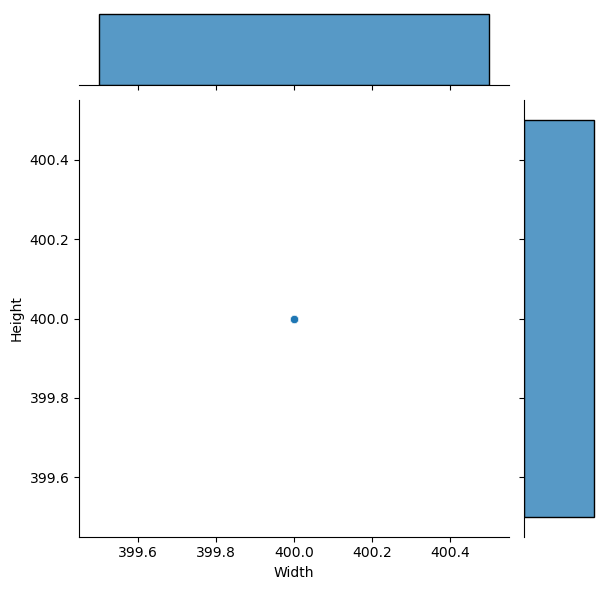

In [83]:
# Interactive plotting with seaborn
sns.jointplot(x='Width', y='Height', data=train_df, kind='scatter')

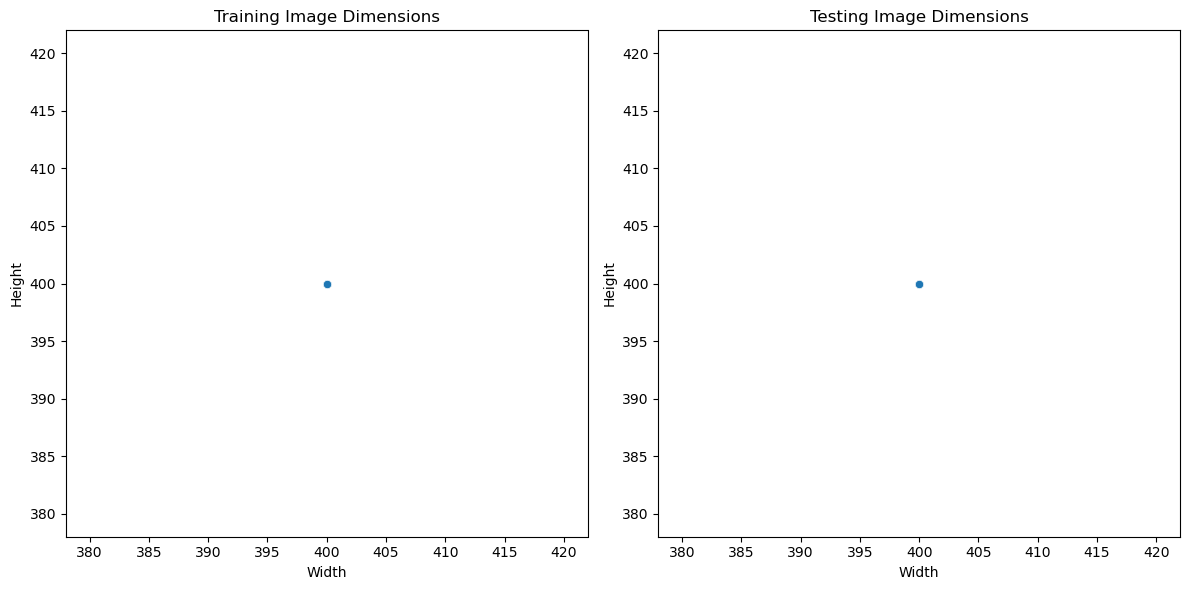

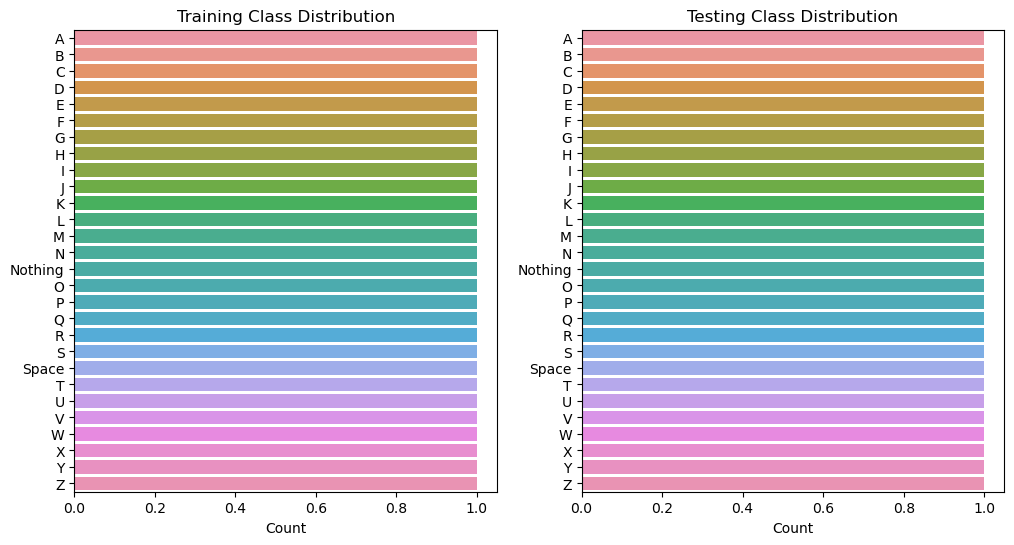

In [90]:
# Plotting image dimensions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=[d[0] for d in train_dimensions], y=[d[1] for d in train_dimensions])
plt.title('Training Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')

plt.subplot(1, 2, 2)
sns.scatterplot(x=[d[0] for d in test_dimensions], y=[d[1] for d in test_dimensions])
plt.title('Testing Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')

plt.tight_layout()
plt.show()

# Plot class distribution
train_classes = [cls for cls in os.listdir(dirTrain) if os.path.isdir(os.path.join(dirTrain, cls))]
test_classes = [cls for cls in os.listdir(dirTest) if os.path.isdir(os.path.join(dirTest, cls))]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(y=train_classes)
plt.title('Training Class Distribution')
plt.xlabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(y=test_classes)
plt.title('Testing Class Distribution')
plt.xlabel('Count')

#plt.tight_layout()
plt.show()


<Axes: xlabel='Height', ylabel='Count'>

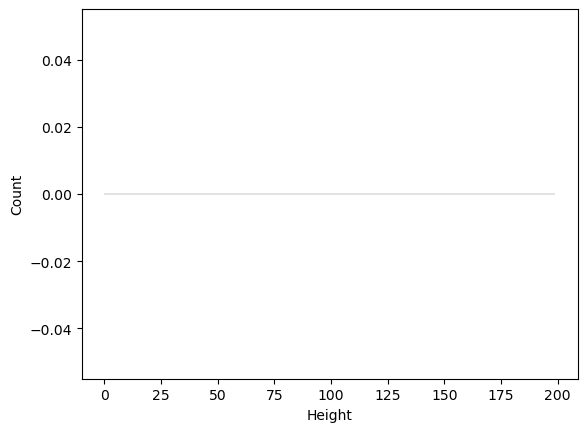

In [93]:
width_range = (0, 200)
height_range = (0, 200)
sns.histplot(test_df['Height'], bins=range(*height_range), kde=False)

In [3]:
# make sure the number of labels matches
if os.listdir(dirTrain) == os.listdir(dirVal):
    labels = os.listdir(dirTrain)
print(labels)
print()
print("length of labels:",len(labels))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

length of labels: 28


In [4]:
N=[]
for i in range(len(labels)):
    N+=[i]
    
mapping=dict(zip(labels,N)) 
reverse_mapping=dict(zip(N,labels)) 

def mapper(value):
    return reverse_mapping[value]

In [5]:
mapping , reverse_mapping

({'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13,
  'Nothing': 14,
  'O': 15,
  'P': 16,
  'Q': 17,
  'R': 18,
  'S': 19,
  'Space': 20,
  'T': 21,
  'U': 22,
  'V': 23,
  'W': 24,
  'X': 25,
  'Y': 26,
  'Z': 27},
 {0: 'A',
  1: 'B',
  2: 'C',
  3: 'D',
  4: 'E',
  5: 'F',
  6: 'G',
  7: 'H',
  8: 'I',
  9: 'J',
  10: 'K',
  11: 'L',
  12: 'M',
  13: 'N',
  14: 'Nothing',
  15: 'O',
  16: 'P',
  17: 'Q',
  18: 'R',
  19: 'S',
  20: 'Space',
  21: 'T',
  22: 'U',
  23: 'V',
  24: 'W',
  25: 'X',
  26: 'Y',
  27: 'Z'})

In [6]:
# Data augmentation for training
setTrain = ImageDataGenerator(rescale = 1.0/255,
                              horizontal_flip = True, # for right(opposite) hand
                              vertical_flip=True,
                              rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.1,
                              fill_mode = 'nearest',
                              brightness_range = [0.5, 2.5],
                              zoom_range = 0.30)

# Data augmentation for validation
setVal = ImageDataGenerator(rescale = 1.0/255)

# Data augmentation for test data
setTest = ImageDataGenerator(rescale = 1.0/255)


In [7]:
# Load and prepare training data
genTrain = setTrain.flow_from_directory(dirTrain,
                                        target_size = (200, 200),
                                        batch_size = 32,
                                        class_mode = 'categorical',
                                        seed = 100)

# Load and prepare validation data
genVal = setVal.flow_from_directory(dirVal,
                                    target_size = (200, 200),
                                    batch_size = 32,
                                    class_mode = 'categorical',
                                    seed = 100)


# Load and prepare testing data
genTest = setTest.flow_from_directory(dirTest,
                                    target_size = (200, 200),
                                    batch_size = 32,
                                    class_mode = 'categorical',
                                    seed = 100)

Found 132543 images belonging to 28 classes.
Found 33127 images belonging to 28 classes.
Found 112 images belonging to 28 classes.


### Model

In [8]:
def cnn_model():
    model = Sequential()
    input_shape = (200, 200, 3)
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))  # Add dropout for regularization
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Add dropout for regularization
    model.add(layers.Dense(len(labels), activation='softmax'))
    
    return model


In [9]:
# show the model summary
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 128)       0

In [10]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [13]:
model.fit(genTrain,
          batch_size = 20,
          steps_per_epoch = 10 ,
          epochs = 20,
          validation_data = genVal)

Epoch 1/20
10/10 [==============================] - 315s 35s/step - loss: 3.3274 - accuracy: 0.0344 - val_loss: 3.3205 - val_accuracy: 0.0641
Epoch 2/20
10/10 [==============================] - 308s 34s/step - loss: 3.3177 - accuracy: 0.0594 - val_loss: 3.3170 - val_accuracy: 0.0725
Epoch 3/20
10/10 [==============================] - 343s 38s/step - loss: 3.2969 - accuracy: 0.0594 - val_loss: 3.2823 - val_accuracy: 0.0723
Epoch 4/20
10/10 [==============================] - 335s 37s/step - loss: 3.3031 - accuracy: 0.0562 - val_loss: 3.2871 - val_accuracy: 0.0787
Epoch 5/20
10/10 [==============================] - 354s 39s/step - loss: 3.2970 - accuracy: 0.0781 - val_loss: 3.2572 - val_accuracy: 0.0735
Epoch 6/20
10/10 [==============================] - 328s 36s/step - loss: 3.2691 - accuracy: 0.0781 - val_loss: 3.2403 - val_accuracy: 0.0718
Epoch 7/20
10/10 [==============================] - 343s 38s/step - loss: 3.2267 - accuracy: 0.0594 - val_loss: 3.2290 - val_accuracy: 0.0862
Epoch 

In [31]:
"""Forgot to store model.fit to a variable"""

# # save model training history into several variables
# acc = model.history.history['accuracy']
# valAcc = model.history.history['val_accuracy']
# epoch = model.history.epoch

# # configure the visualization
# plt.subplots(figsize=(8, 4))
# plt.plot(epoch, acc, label = 'Data Training', color = 'b')
# plt.plot(epoch, valAcc, label = 'Data Validation', color = 'r')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.xlim([0, len(epoch)])
# plt.ylim([0, 1])
# plt.title('History Accuracy Graph')

# # and show it!
# plt.legend()
# plt.show()


'Forgot to store model.fit to a variable'

In [14]:
model.save("model.h5")


C:\Users\vipul\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# save all those labels
y_test = genTest.classes
y_test

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
       21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25,
       25, 25, 26, 26, 26, 26, 27, 27, 27, 27])

In [58]:
# prediction
y_pred = []
for i in genTest.class_indices:
    # take the path of data test
    labelTest = dirTest+'/'+i+'/'
    for j in os.listdir(labelTest):
        # save the label
        x_pred = labelTest + j
        print()
        print(x_pred)
        
        # load image into matrix
        img = image.load_img(x_pred, target_size = (200, 200))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        matxImg = np.vstack([x])

        
        predict = model.predict(matxImg, batch_size = 32)
        predict = np.argmax(predict, axis = 1)
        y_pred.append(predict[0])


C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/A/3001.jpg
1/1 [==============================] - 0s 122ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/A/3002.jpg
1/1 [==============================] - 0s 44ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/A/3003.jpg
1/1 [==============================] - 0s 43ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/A/3004.jpg
1/1 [==============================] - 0s 46ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/B/3001.jpg
1/1 [==============================] - 0s 43ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/B/3002.jpg
1/1 [==============================] - 0s 43ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/B/3003.jpg
1/1 [==============================] - 0s 45ms/step

C:/Users/vipul/Documents/

1/1 [==============================] - 0s 52ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/Nothing/3004.jpg
1/1 [==============================] - 0s 43ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/O/3001.jpg
1/1 [==============================] - 0s 42ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/O/3002.jpg
1/1 [==============================] - 0s 46ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/O/3003.jpg
1/1 [==============================] - 0s 45ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/O/3004.jpg
1/1 [==============================] - 0s 45ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/P/3001.jpg
1/1 [==============================] - 0s 45ms/step

C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset\Test/P/3002.jpg
1/1 [================

In [32]:
# calculate the accuracy of the prediction
acc_result = round(accuracy_score(y_pred, y_test), 2)
print('Accuracy: ', acc_result)

Accuracy:  0.19


In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       1.00      0.25      0.40         4
           4       0.25      1.00      0.40         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.50      1.00      0.67         4
          13       0.00      0.00      0.00         4
          14       1.00      1.00      1.00         4
          15       0.00      0.00      0.00         4
          16       0.33      1.00      0.50         4
          17       0.00    

C:\Users\vipul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vipul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vipul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

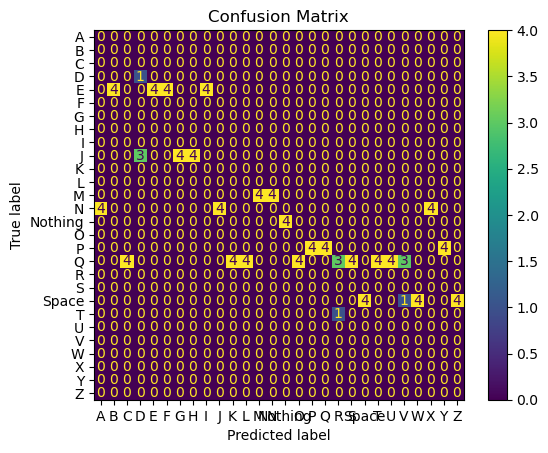

In [36]:
# show the confusion matrix
conf_matrix = confusion_matrix(y_pred, y_test,
                          labels = list(genTest.class_indices.values()))

ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                       display_labels = list(genTest.class_indices.keys())).plot()
plt.title('Confusion Matrix')

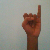

In [40]:
load_img("C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset/Test/I/3001.jpg",target_size=(50,50))

In [63]:
image_file = load_img("C:/Users/vipul/Documents/MSU - MSDS/CMSE/Project mid term/ASL_Dataset/Test/I/3001.jpg",target_size=(200,200))
image_file=img_to_array(image_file) 
image_file=image_file/255.0
pred_image=np.array(image_file)
pred_image= np.expand_dims(pred_image, axis=0)

In [69]:
prediction=model.predict(pred_image)
value=np.argmax(prediction)
sign_name=mapper(value)
print("Prediction is {}.".format(sign_name))

1/1 [==============================] - 0s 54ms/step
Prediction is E.


In [94]:
!pip install pipreqs


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13775 sha256=325ae451b89b8f7200f889d6a66ba3b63a5fe5a514af9640af72a55336668ba5
  Stored in directory: c:\users\vipul\appdata\local\pip\cache\wheels\1a\b0\8c\4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt


In [95]:
!pip show pillow


Name: Pillow
Version: 9.4.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: C:\Users\vipul\anaconda3\Lib\site-packages
Requires: 
Required-by: bokeh, datashader, imageio, matplotlib, scikit-image, streamlit
